# EDA (Exploratory Data Analysis)
EDA is a method of exploring through a given set of data, finding and cleaning outliers, and ultimately preparing the data for ML model training.  In contrast to many public/open datasets, this dataset is fairly clean and consistent, possibly because of legal oversight.  

Regardless, I will thankfully be able to focus more on analyzing the data than fixing and cleaning it.

## A Brief Aside for Unexpected Empathy
Having turned the corner on much of the EDA, I suddenly understand why officers are so reluctant to take actions because of the "paperwork".  

At 81 discrete data points which need to be vetted and validated, a couple of stop and frisk interactions could easily take up an entire afternoon of data entry.  I say this after seeing the [astronomical stop and frisk numbers prior to 2017](https://datacollaborativeforjustice.org/dashboard-sqf/) and reviewing the data from the same period.  There's orders of magnitude less data collected from that period despite a stop rate of up to 25k stops / 100,000 persons, or ~600,000 total stops in 2016 vs the ~25,000 stops in 2024*.  

One of the primary drivers of keeping these rates as low as they are might very well be the raw data entry time required to process that many events.

But, I digress....

# Unsupervised Learning Update
Having turned the corner on munging all of the data from 2021-24 together, this data was not clean and sometimes seemed outright performative after manually reviewing the data and seeing records that are quite literally the bare minimum, if that.  

I say that in context of the report in the references stating that ~40% of all stops aren't even recorded in this dataset, and how we can only use 83% of the remaining data.



In [1]:
import numpy as np
import pandas as pd
from utils.model_training import prepare_model_features, visualize_features
import seaborn as sns



In [2]:
df = pd.read_csv(
    "./data/processed/stop-and-frisk.csv",
    parse_dates=["STOP_FRISK_DATE"],  
)
# df.info()

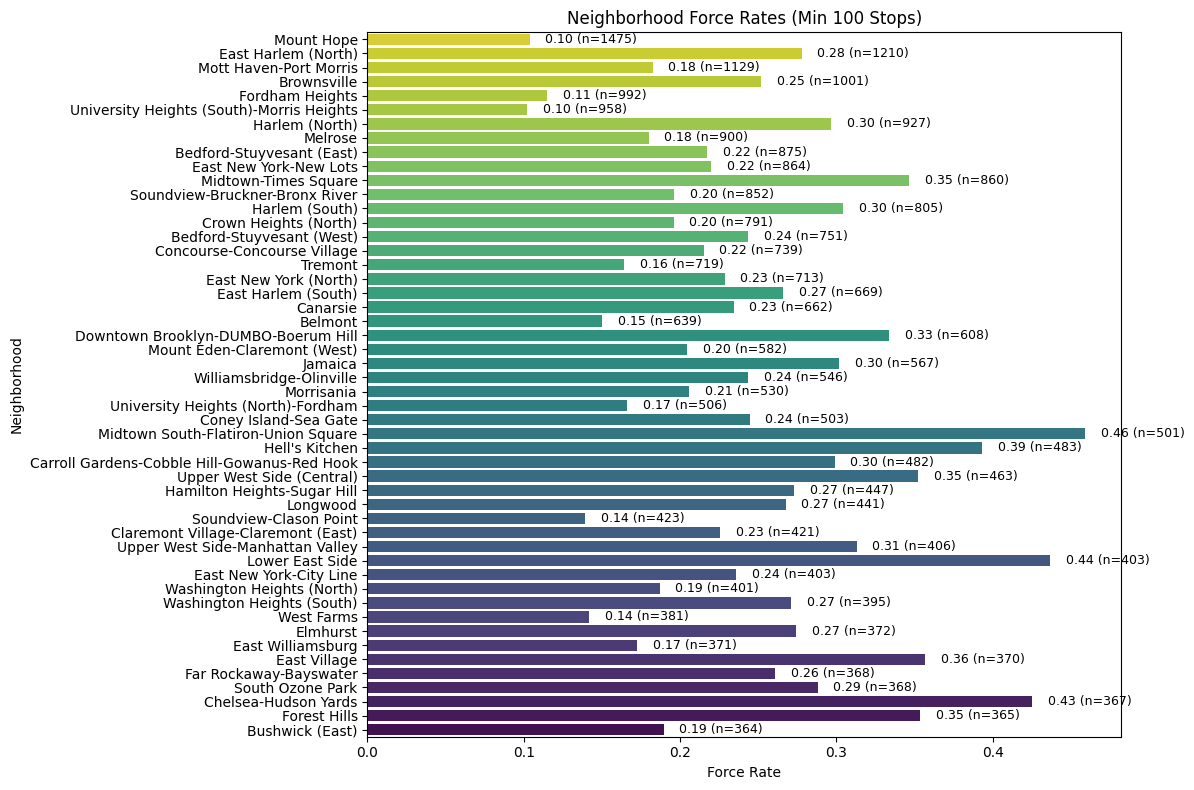

In [ ]:
# Todo: cleanup + reorder

import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
neighborhood_force = df[['NEIGHBORHOOD']].dropna()
neighborhood_force_rates = df.groupby('NEIGHBORHOOD')['OFFICER_USED_FORCE'].mean()
df['NEIGHBORHOOD_FORCE_RATE'] = df['NEIGHBORHOOD'].map(neighborhood_force_rates)

neighborhood_force = df.groupby('NEIGHBORHOOD')['NEIGHBORHOOD_FORCE_RATE'].mean().sort_values(ascending=False)

top_n = 50
neighborhood_force_top = neighborhood_force.nlargest(top_n)

MIN_STOPS = 100  

# 1. Calculate stop counts per neighborhood
neighborhood_stats = df.groupby('NEIGHBORHOOD').agg(
    TOTAL_STOPS=('NEIGHBORHOOD_FORCE_RATE', 'count'),
    FORCE_RATE=('NEIGHBORHOOD_FORCE_RATE', 'mean')
)

# 2. Filter neighborhoods meeting the threshold
qualified_neighborhoods = neighborhood_stats[neighborhood_stats['TOTAL_STOPS'] >= MIN_STOPS]
qualified_neighborhoods = qualified_neighborhoods.sort_values('TOTAL_STOPS', ascending=False)
qualified_neighborhoods = qualified_neighborhoods.nlargest(top_n, ['TOTAL_STOPS'])
# 3. Create the visualization
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='FORCE_RATE',
    y=qualified_neighborhoods.index,
    data=qualified_neighborhoods,
    palette="viridis_r",
    hue=qualified_neighborhoods.index,
    # legend=False,
    order=qualified_neighborhoods.index  # Maintain sorted order
)

# 4. Annotate with both rate and count
for i, (rate, count) in enumerate(zip(qualified_neighborhoods['FORCE_RATE'], 
                                   qualified_neighborhoods['TOTAL_STOPS'])):
    ax.text(rate + 0.01, i, 
            f'{rate:.2f} (n={count})', 
            va='center', 
            fontsize=9)

plt.title(f'Neighborhood Force Rates (Min {MIN_STOPS} Stops)')
plt.xlabel('Force Rate')
plt.ylabel('Neighborhood')
plt.tight_layout()

## For the Children
Before analyzing the dataset at large, I did want to segment off the events targeted at children.  Children represent ~19.8% of the total NYC population as of the 2020 census, yet represent 16% of the overall stops.  Given the problems of stop and frisk, this number should be 0, but let's assume that the procedure is legitimate.  Superficially, you'd expect some 1:1ish ratio for any demographic assuming that there's a constant rate of crime for all individuals.  Clearly this assumption doesn't fit reality, but for the sake of argument and statistical clarity, we will assume its true.  

Well, that leads us to the first incongruity, in that young children aren't really committing crimes at equal levels as their older counterparts.  Specifically, while we have zero cases for children under 6, we actually begin to see a great deal of stop and frisk as early as 7 years old.  So to make the numbers a bit more aligned, I will calcuate the percentage of cases for children excluding 5 years old and below for both populations.  In general, rather than representing ~20% of NYC, 6-17 year olds comprise ~14% of the city, edging them towards the terrain of being overpoliced given that they are 15% of the city, but represent 16% of the stop and frisk events. 

In [ ]:
number_of_nyc_children = 1740142
number_of_children_under_5 = 475637
total_nyc_population = 8804190
percentage_of_children_in_nyc = (number_of_nyc_children ) / (total_nyc_population ) * 100
percentage_of_6_to_17_children = (number_of_nyc_children - number_of_children_under_5) / (total_nyc_population - number_of_children_under_5) * 100
print(f"6-17 year olds represent {percentage_of_6_to_17_children:.2f}% of all New Yorkers vs the percentage of all children in NYC: {percentage_of_children_in_nyc:.2f}% ")

6-17 year olds represent 15.18% of all New Yorkers vs the percentage of all children in NYC: 19.76% 


In [ ]:
# For the children, prepping children specific dataframes for analysis
demographic_features = [
    'SUSPECT_REPORTED_AGE', 
    'SUSPECT_RACE_DESCRIPTION',
    'STOP_WAS_INITIATED',
    'SUSPECTED_CRIME_DESCRIPTION',
    'OFFICER_EXPLAINED_STOP_FLAG',
    'OUTCOME_OF_STOP',
    'FORCE_TYPE',
    # 'SUSPECT_HEIGHT',
    # 'SUSPECT_SEX',
    'STOP_LOCATION_BORO_NAME',
]
demographic_df = final_df[demographic_features].copy()

all_children_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] < 18].copy()
under_13_df = demographic_df[demographic_df['SUSPECT_REPORTED_AGE'] <= 12].copy()
under_13_df['SUSPECT_REPORTED_AGE'].value_counts()
 
print(f'{len(all_children_df)} total records of children targeted stops, where children comprise {len(all_children_df) / len(demographic_df)*100:.2f}% of all stops')

3260 total records of children targeted stops, where children comprise 16.10% of all stops


In [ ]:
from pandas import DataFrame
# All the table/graph rendering code...

RACE_LABEL_OVERRIDES = {
    'AMERICAN INDIAN/ALASKAN NATIVE': "American Indian/Alaskan Native",
    "BLACK": "Black",
    "WHITE": "White",
    'BLACK HISPANIC': 'Hispanic (Black)',
    'WHITE HISPANIC': 'Hispanic (White)',
    'MIDDLE EASTERN/SOUTHWEST ASIAN': 'ME/SW Asian',
    'ASIAN / PACIFIC ISLANDER': 'Asian/PI',
}

# Create summary tables
def show_demographic_table(demo_table: DataFrame, title, index_title=""):  
    # Calculate row and column totals for percentage calcs...
    demo_table['ROW TOTAL'] = demo_table.sum(axis=1)
    col_totals = pd.DataFrame([demo_table.sum()], index=['TOTAL'])
   
    # Calculate percentages
    grand_total = demo_table['ROW TOTAL'].sum()
    col_pct = pd.DataFrame([(demo_table.sum() / grand_total * 100).round(1)], index=['% OF TOTAL'])
   
    # Combine all components
    final_table = pd.concat([demo_table, col_totals, col_pct])
    final_table.rename_axis(columns=None)
    
    # Apply styling
    # final_table.index.name = index_title
    styled = final_table.style.set_caption(title)
    
    
    # Format only numeric cells with integers (avoiding the percentage row)
    styled = styled.format('{:,}', subset=pd.IndexSlice[demo_table.index.tolist() + ['TOTAL'], :])
    
    # Format percentage row
    styled = styled.format('{:.1f}%', subset=pd.IndexSlice['% OF TOTAL', :])
    
    # Add other styling
    styled = styled.background_gradient(cmap='Blues', subset=pd.IndexSlice[demo_table.index, :])
    styled = styled.set_table_styles([
        {'selector': 'tr:nth-last-child(2)', 'props': 'border-top: 2px solid black;'},
        {'selector': 'tr:last-child', 'props': 'border-top: 1px solid black;'},
        {'selector': '.row_heading', 'props': 'text-align: left;'},
        {'selector': 'caption', 'props': 'caption-side: top; font-size: 1.2em; font-weight: bold;'}
    ])
    # styled = styled.highlight_max(axis=0, subset=pd.IndexSlice[demo_table.index, :], color='#ffeb99')
    return styled

def plot_stop_outcomes(df, n_reasons=5, figsize=(14, 8), plot_title = "Policing Outcomes by Race and Stop Reason of 6-12 Year Olds"):
    # 1. Aggregate data safely
    outcomes = (
        df.groupby(['SUSPECT_RACE_DESCRIPTION', 
                   'SUSPECTED_CRIME_DESCRIPTION', 
                   'OUTCOME_OF_STOP'])
        .size()
        .unstack()
        .fillna(0)
    )
    
    # 2. Get top reasons that actually exist in data
    valid_reasons = df['SUSPECTED_CRIME_DESCRIPTION'].value_counts().nlargest(n_reasons).index
    valid_reasons = [r for r in valid_reasons if r in outcomes.index.get_level_values(1)]
    
    # 3. Set up plot
    n_cols = min(3, len(valid_reasons))
    n_rows = (len(valid_reasons) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # 4. Color palette for whatever outcomes exist
    palette = {
        'Arrested': '#e63946',
        'Summoned': '#457b9d', 
        'No Charges Filed': '#a8dadc',
        'Other': '#1d3557'  # Fallback
    }
    
    # 5. Plot each reason
    for i, reason in enumerate(valid_reasons):
        ax = axes[i]
        reason_data = outcomes.xs(reason, level='SUSPECTED_CRIME_DESCRIPTION')
        
        # Normalize and get ACTUAL existing outcomes
        reason_data = reason_data.div(reason_data.sum(axis=1), axis=0)
        existing_outcomes = [col for col in reason_data.columns if reason_data[col].sum() > 0]
        
        labels = [
            RACE_LABEL_OVERRIDES.get(race, race[:12] + '...' if len(race) > 12 else race)
            for race in reason_data.index
        ]
        
        # Dynamically plot available outcomes
        reason_data[existing_outcomes].plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[palette.get(o, '#999999') for o in existing_outcomes],
            width=0.8
        )
        
        # Set custom labels
        ax.set_xticklabels(labels, rotation=45, ha='right')
        
        # Formatting
        ax.set_title(f"{reason[:20]}..." if len(reason) > 20 else reason, pad=10)
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.tick_params(axis='x', rotation=45)
        
        # Only show legend on first plot
        if i != 0:
            ax.get_legend().remove()
        else:
            ax.legend(title='Outcome', bbox_to_anchor=(1, 1))

    # Clean up empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle(plot_title, y=1.02, fontsize=14)
    plt.show()

### Glossary of Police Terms 
Most of this type of analysis is outside my wheelhouse, so we're learning about these terms together

#### Stop Initiated Codes
Surprisingly, there is no official NYPD documentation for these values that I could find, even in its data dictionary.  Moreover, these code have changed over time in the stop and frisk datasets themselves.  As such, this is the best that I could glean from searching more broadly for reader transparency.

- Based on C/W on Scene: Based upon a complaint/witness or other third party
- Based on Radio Run: Officer was dispatched to investigate by headquarters
- Based on Self Initiated:  Officer initiated the stop and frisk interaction

#### Crime Definitions
Below is a glossary of common crime categories used in NYPD stop-and-frisk data, with definitions and direct references to the relevant sections of New York State law on [nysenate.gov](https://www.nysenate.gov/legislation/laws/PEN). Each entry includes a brief definition and a markdown link to the official legislative text where available.

They are ordered by most severe to least severe

## Misdemeanors

**ASSAULT (Third Degree)**  
Causing physical injury to another person.  
[§120.00 Assault in the third degree](https://www.nysenate.gov/legislation/laws/PEN/120.00)

**MENACING (Second Degree)**  
Placing another person in fear of imminent physical injury.  
[§120.14 Menacing in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.14)

**RECKLESS ENDANGERMENT (Second Degree)**  
Recklessly creating a substantial risk of serious physical injury.  
[§120.20 Reckless endangerment in the second degree](https://www.nysenate.gov/legislation/laws/PEN/120.20)

**FORCIBLE TOUCHING**  
Intentionally touching another person in a sexual manner without consent.  
[§130.52 Forcible touching](https://www.nysenate.gov/legislation/laws/PEN/130.52)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Misdemeanor Levels)**  
Possessing certain weapons unlawfully.  
[§265.01 Criminal possession of a weapon in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/265.01)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Misdemeanor Levels)**  
Possessing small amounts for personal use.  
[§220.03 Criminal possession of a controlled substance in the seventh degree](https://www.nysenate.gov/legislation/laws/PEN/220.03)

**CRIMINAL SALE OF MARIHUANA (Misdemeanor Levels)**  
Unlawfully selling small amounts of marijuana.  
[§221.40 Criminal sale of marihuana in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/221.40) *(Repealed, but historically relevant)*

**CRIMINAL POSSESSION OF MARIHUANA (Misdemeanor Levels)**  
Unlawful possession of marijuana.  
[§221.10 Criminal possession of marihuana in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/221.10) *(Repealed, but historically relevant)*

**CRIMINAL TRESPASS (Second Degree)**  
Knowingly entering or remaining unlawfully in a dwelling.  
[§140.15 Criminal trespass in the second degree](https://www.nysenate.gov/legislation/laws/PEN/140.15)

**CRIMINAL MISCHIEF (Fourth Degree)**  
Intentionally damaging another person's property.  
[§145.00 Criminal mischief in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/145.00)

**PETIT LARCENY**  
Theft of property valued at $1,000 or less.  
[§155.25 Petit larceny](https://www.nysenate.gov/legislation/laws/PEN/155.25)

**THEFT OF SERVICES**  
Obtaining services without paying.  
[§165.15 Theft of services](https://www.nysenate.gov/legislation/laws/PEN/165.15)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Misdemeanor Levels)**  
Knowingly possessing stolen property valued at $1,000 or less.  
[§165.40 Criminal possession of stolen property in the fifth degree](https://www.nysenate.gov/legislation/laws/PEN/165.40)

**AUTO STRIPPING (Misdemeanor Levels)**  
Removing parts from a vehicle without the owner's permission.  
[§165.09 Auto stripping in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.09)

**UNAUTHORIZED USE OF A VEHICLE (Third Degree)**  
Using a vehicle without the owner's consent.  
[§165.05 Unauthorized use of a vehicle in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.05)

**MAKING GRAFFITI**  
Marking property with graffiti without the owner's permission.  
[§145.60 Making graffiti](https://www.nysenate.gov/legislation/laws/PEN/145.60)

**CRIMINAL POSSESSION OF FORGED INSTRUMENT (Misdemeanor Levels)**  
Possessing a forged document with intent to defraud.  
[§170.20 Criminal possession of a forged instrument in the third degree](https://www.nysenate.gov/legislation/laws/PEN/170.20)

**PROSTITUTION**  
Engaging in, agreeing to, or offering sexual conduct for a fee.  
[§230.00 Prostitution](https://www.nysenate.gov/legislation/laws/PEN/230.00)

## Felonies

**MURDER**  
Intentionally causing the death of another person.  
[§125.25 Murder in the second degree](https://www.nysenate.gov/legislation/laws/PEN/125.25)

**TERRORISM**  
Acts intended to intimidate or coerce a civilian population or influence government policy.  
[§490.25 Crime of terrorism](https://www.nysenate.gov/legislation/laws/PEN/490.25)

**RAPE**  
Engaging in sexual intercourse with another person without consent.  
[§130.35 Rape in the first degree](https://www.nysenate.gov/legislation/laws/PEN/130.35)

**ROBBERY**  
Forcibly stealing property from another by force or threat of force.  
[§160.15 Robbery in the first degree](https://www.nysenate.gov/legislation/laws/PEN/160.15)

**BURGLARY**  
Illegally entering a building with intent to commit a crime, usually theft.  
[§140.30 Burglary in the first degree](https://www.nysenate.gov/legislation/laws/PEN/140.30)

**ASSAULT (First Degree)**  
Causing serious physical injury to another person with intent.  
[§120.10 Assault in the first degree](https://www.nysenate.gov/legislation/laws/PEN/120.10)

**CRIMINAL SALE OF CONTROLLED SUBSTANCE**  
Selling illegal drugs or controlled substances.  
[§220.43 Criminal sale of a controlled substance in the first degree](https://www.nysenate.gov/legislation/laws/PEN/220.43)

**CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE (Felony Levels)**  
Possessing large quantities or with intent to sell.  
[§220.16 Criminal possession of a controlled substance in the third degree](https://www.nysenate.gov/legislation/laws/PEN/220.16)

**GRAND LARCENY**  
Theft of property valued above $1,000.  
[§155.30 Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**GRAND LARCENY AUTO**  
Theft of a motor vehicle valued above $1,000.  
[§155.30(8) Grand larceny in the fourth degree](https://www.nysenate.gov/legislation/laws/PEN/155.30)

**CRIMINAL POSSESSION OF A WEAPON (CPW) (Felony Levels)**  
Possessing a firearm or other weapon unlawfully (felony levels).  
[§265.03 Criminal possession of a weapon in the second degree](https://www.nysenate.gov/legislation/laws/PEN/265.03)

**CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP) (Felony Levels)**  
Knowingly possessing stolen property valued above $1,000.  
[§165.45 Criminal possession of stolen property in the third degree](https://www.nysenate.gov/legislation/laws/PEN/165.45)

**AUTO STRIPPING (Felony Levels)**  
Removing parts from a vehicle causing damage over $1,000.  
[§165.11 Auto stripping in the first degree](https://www.nysenate.gov/legislation/laws/PEN/165.11)

---

## Felony or Misdemeanor (Depends on Circumstances)

Some crimes can be classified as either a misdemeanor or felony depending on the value involved, the presence of weapons, injury, or prior convictions:

- ASSAULT
- CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE
- CRIMINAL POSSESSION OF A WEAPON (CPW)
- CRIMINAL POSSESSION OF STOLEN PROPERTY (CPSP)
- AUTO STRIPPING
- CRIMINAL POSSESSION OF FORGED INSTRUMENT
- CRIMINAL TRESPASS
- CRIMINAL MISCHIEF
- UNAUTHORIZED USE OF A VEHICLE
- CRIMINAL SALE OF MARIHUANA


In [ ]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "All Stops of Children under 13 by Age and Race", 'Age / Suspect')


SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,39.0,3.0,1.0,6.0,9.0,58.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


## Exploring the data
In general, I will briefly analyze three slices of New Yorkers, children under 13, all children under 18, and all New Yorkers at large.  Each analysis will largely follow a loose sequence of events defined in the data, namely who initated the stop, for what reason, what type of force did the police use if any, and ultimately to what outcome for the targeted individual.

In [ ]:
under_13_demo_table = (
    under_13_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What inititated the stop of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,12.0,1.0,0.0,1.0,1.0,15.0
Based on Radio Run,0.0,32.0,3.0,0.0,10.0,9.0,54.0
Based on Self Initiated,1.0,9.0,1.0,1.0,0.0,3.0,15.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [ ]:
under_13_demo_table = (
    under_13_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,5.0,1.0,1.0,1.0,2.0,10.0
BURGLARY,1.0,3.0,0.0,0.0,0.0,0.0,4.0
CPW,0.0,11.0,3.0,0.0,7.0,1.0,22.0
CRIMINAL MISCHIEF,0.0,2.0,0.0,0.0,1.0,1.0,4.0
CRIMINAL TRESPASS,0.0,0.0,0.0,0.0,0.0,2.0,2.0
GRAND LARCENY,0.0,3.0,0.0,0.0,0.0,1.0,4.0
GRAND LARCENY AUTO,0.0,1.0,0.0,0.0,1.0,0.0,2.0
MENACING,0.0,3.0,1.0,0.0,0.0,0.0,4.0
OTHER,0.0,1.0,0.0,0.0,0.0,0.0,1.0
PETIT LARCENY,0.0,4.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
# print("Unique values in OFFICER_USED_FORCE:", under_13_df['OFFICER_USED_FORCE'].unique())
# print("Unique values in SUSPECT_RACE_DESCRIPTION:", under_13_df['SUSPECT_RACE_DESCRIPTION'].unique())


under_13_demo_table = (
    under_13_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "Why Did Officers Stop Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,1.0,0.0,0.0,0.0,1.0,2.0
Handcuffs,0.0,9.0,1.0,0.0,1.0,2.0,13.0
No Force,1.0,42.0,4.0,1.0,10.0,10.0,68.0
Restraint Used,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


In [ ]:
under_13_demo_table = (
    under_13_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(under_13_demo_table, "What Were the Outcomes of Stops of Children under 13 by Age and Race")

SUSPECT_RACE_DESCRIPTION,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,0.0,27.0,0.0,0.0,1.0,1.0,29.0
No Charges Filed,1.0,26.0,5.0,1.0,10.0,12.0,55.0
TOTAL,1.0,53.0,5.0,1.0,11.0,13.0,84.0
% OF TOTAL,1.2%,63.1%,6.0%,1.2%,13.1%,15.5%,100.0%


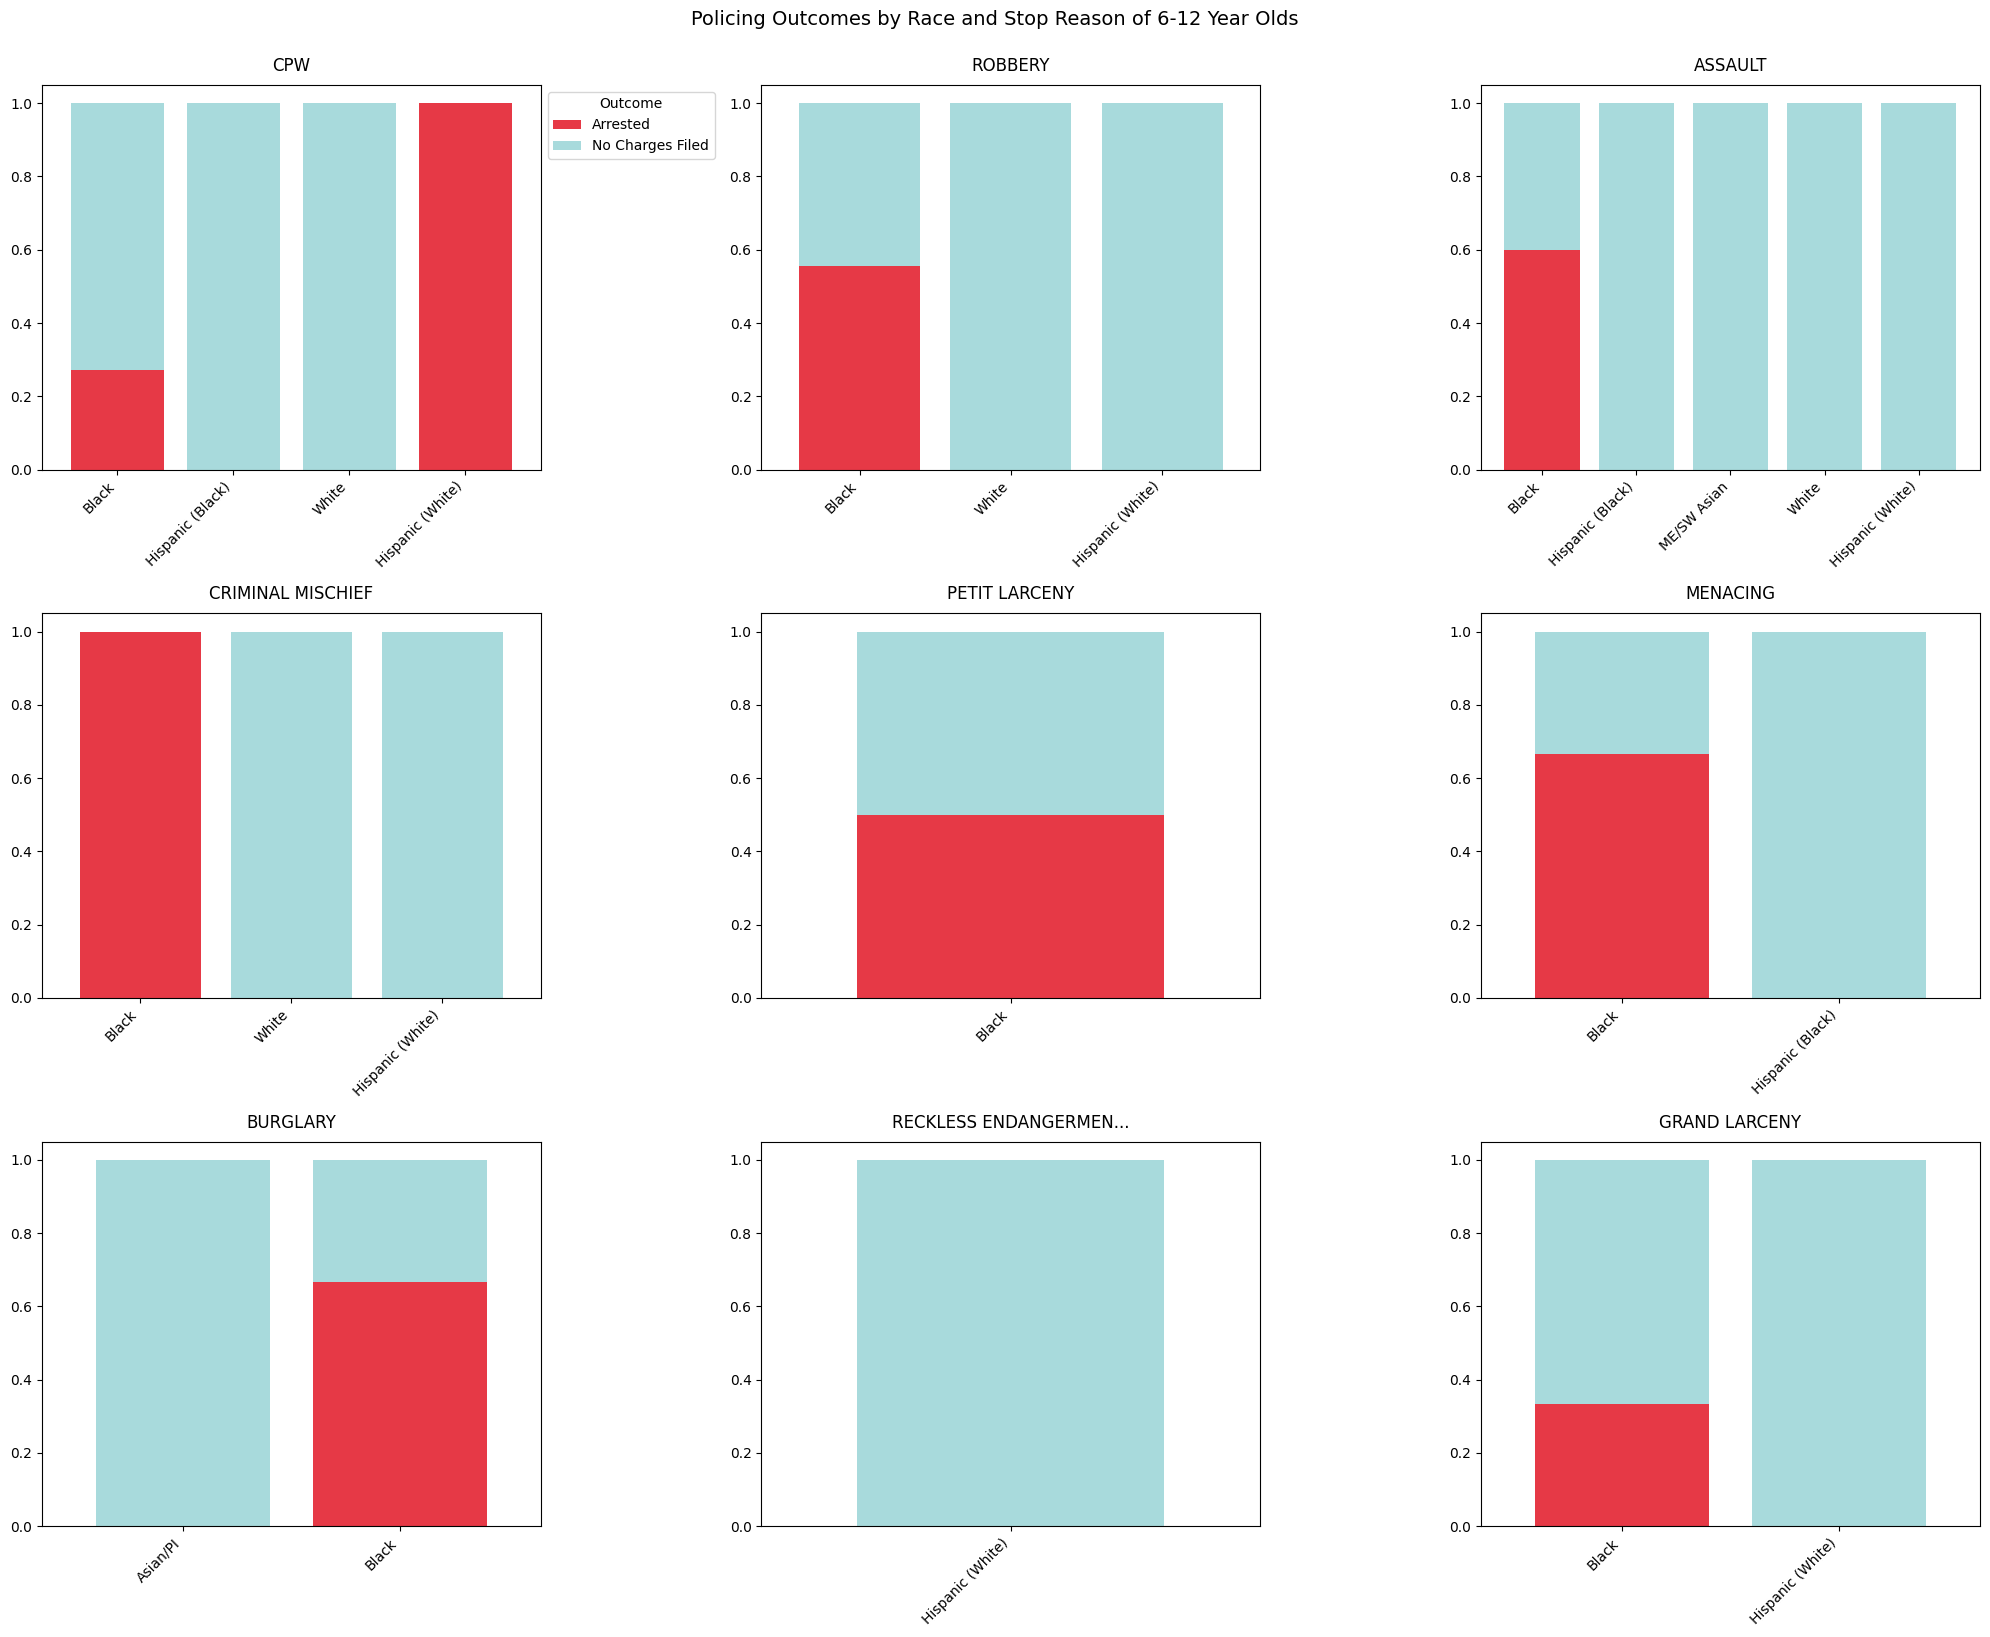

In [ ]:
plot_stop_outcomes(under_13_df, figsize=(20,16), n_reasons=9)

In [ ]:
# If you want to take a look at the raw data:
under_13_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
348,12,BLACK,Based on C/W on Scene,ROBBERY,True,No Charges Filed,Restraint Used,BRONX
533,10,WHITE HISPANIC,Based on Radio Run,CRIMINAL MISCHIEF,True,No Charges Filed,No Force,BROOKLYN
1485,12,BLACK,Based on C/W on Scene,PETIT LARCENY,True,No Charges Filed,No Force,BRONX
2506,12,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
2507,11,WHITE,Based on Radio Run,CPW,True,No Charges Filed,No Force,STATEN ISLAND
...,...,...,...,...,...,...,...,...
19385,11,BLACK,Based on Radio Run,ASSAULT,True,No Charges Filed,No Force,BROOKLYN
19928,9,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS
19929,12,BLACK,Based on Radio Run,ROBBERY,True,No Charges Filed,No Force,QUEENS
19930,12,BLACK,Based on Radio Run,ROBBERY,True,Arrested,No Force,QUEENS


### Not Off to the Best Start...
Thankfully, there are very few stops of pre-teens relative to the general population, but it is still too high.  

We've got kids as young as 7 being stopped by the police.  The earliest arrest was aged 9 for robbery.  Black and Black/Hispanic children make up the overwhelming majority of both stops as well as arrests.  They also comprise the entirety of Menacing charges and arrests, and seem to be the only children arrested for criminal mischief, assault, or robbery.  

One could certainly just come to a conclusion that these children are legitimate criminals at this age reinforcing debunked notions of super predators, but its important to call out that an arrest is not a conviction as well as the completely subjective nature of these interactions.  Any officer could use their discretion to not charge these children, as we see pretty consistently for those children possessing a lighter skin tone.


At 84 records, there's not enough statistical power to definitely prove any biases here, but there's certainly a great deal of smoke even if we can't see the fire.

But onto the Under 18 cohort...

In [ ]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,469.0,72.0,9.0,24.0,137.0,731.0
16,0.0,8.0,564.0,75.0,7.0,26.0,157.0,837.0


In [ ]:
all_children_demo_table = (
    all_children_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "What inititated the stop of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,8.0,197.0,36.0,3.0,14.0,78.0,336.0
Based on Radio Run,3.0,28.0,999.0,138.0,29.0,99.0,265.0,"1,561.0"
Based on Self Initiated,0.0,13.0,972.0,108.0,3.0,27.0,240.0,"1,363.0"
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


In [ ]:
all_children_demo_table = (
    all_children_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "All Stops of Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,1.0,3.0,147.0,24.0,4.0,14.0,61.0,254.0
AUTO STRIPPIG,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
BURGLARY,0.0,2.0,47.0,10.0,1.0,16.0,11.0,87.0
CPSP,0.0,0.0,3.0,2.0,0.0,1.0,2.0,8.0
CPW,0.0,5.0,"1,058.0",113.0,15.0,37.0,235.0,"1,463.0"
CRIMINAL MISCHIEF,1.0,0.0,24.0,3.0,3.0,13.0,7.0,51.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL POSSESSION OF MARIHUANA,0.0,0.0,5.0,0.0,0.0,0.0,2.0,7.0
CRIMINAL SALE OF MARIHUANA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
CRIMINAL TRESPASS,0.0,4.0,53.0,3.0,2.0,5.0,17.0,84.0


In [ ]:
all_children_demo_table = (
    all_children_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Types of Force Used Against All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,0.0,0.0,73.0,9.0,2.0,3.0,16.0,103.0
Handcuffs,0.0,9.0,342.0,51.0,2.0,15.0,82.0,501.0
No Force,3.0,38.0,"1,622.0",205.0,30.0,119.0,455.0,"2,472.0"
Other Physical Force,0.0,2.0,52.0,7.0,1.0,2.0,8.0,72.0
Restraint Used,0.0,0.0,71.0,7.0,0.0,1.0,20.0,99.0
Taser,0.0,0.0,7.0,3.0,0.0,0.0,1.0,11.0
Weapon Impact,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


In [ ]:
all_children_demo_table = (
    all_children_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(all_children_demo_table, "Outcome of Stops of All Children by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,1.0,19.0,752.0,105.0,9.0,44.0,176.0,"1,106.0"
No Charges Filed,2.0,27.0,"1,362.0",166.0,25.0,93.0,381.0,"2,056.0"
Summoned,0.0,3.0,54.0,11.0,1.0,3.0,26.0,98.0
TOTAL,3.0,49.0,"2,168.0",282.0,35.0,140.0,583.0,"3,260.0"
% OF TOTAL,0.1%,1.5%,66.5%,8.7%,1.1%,4.3%,17.9%,100.0%


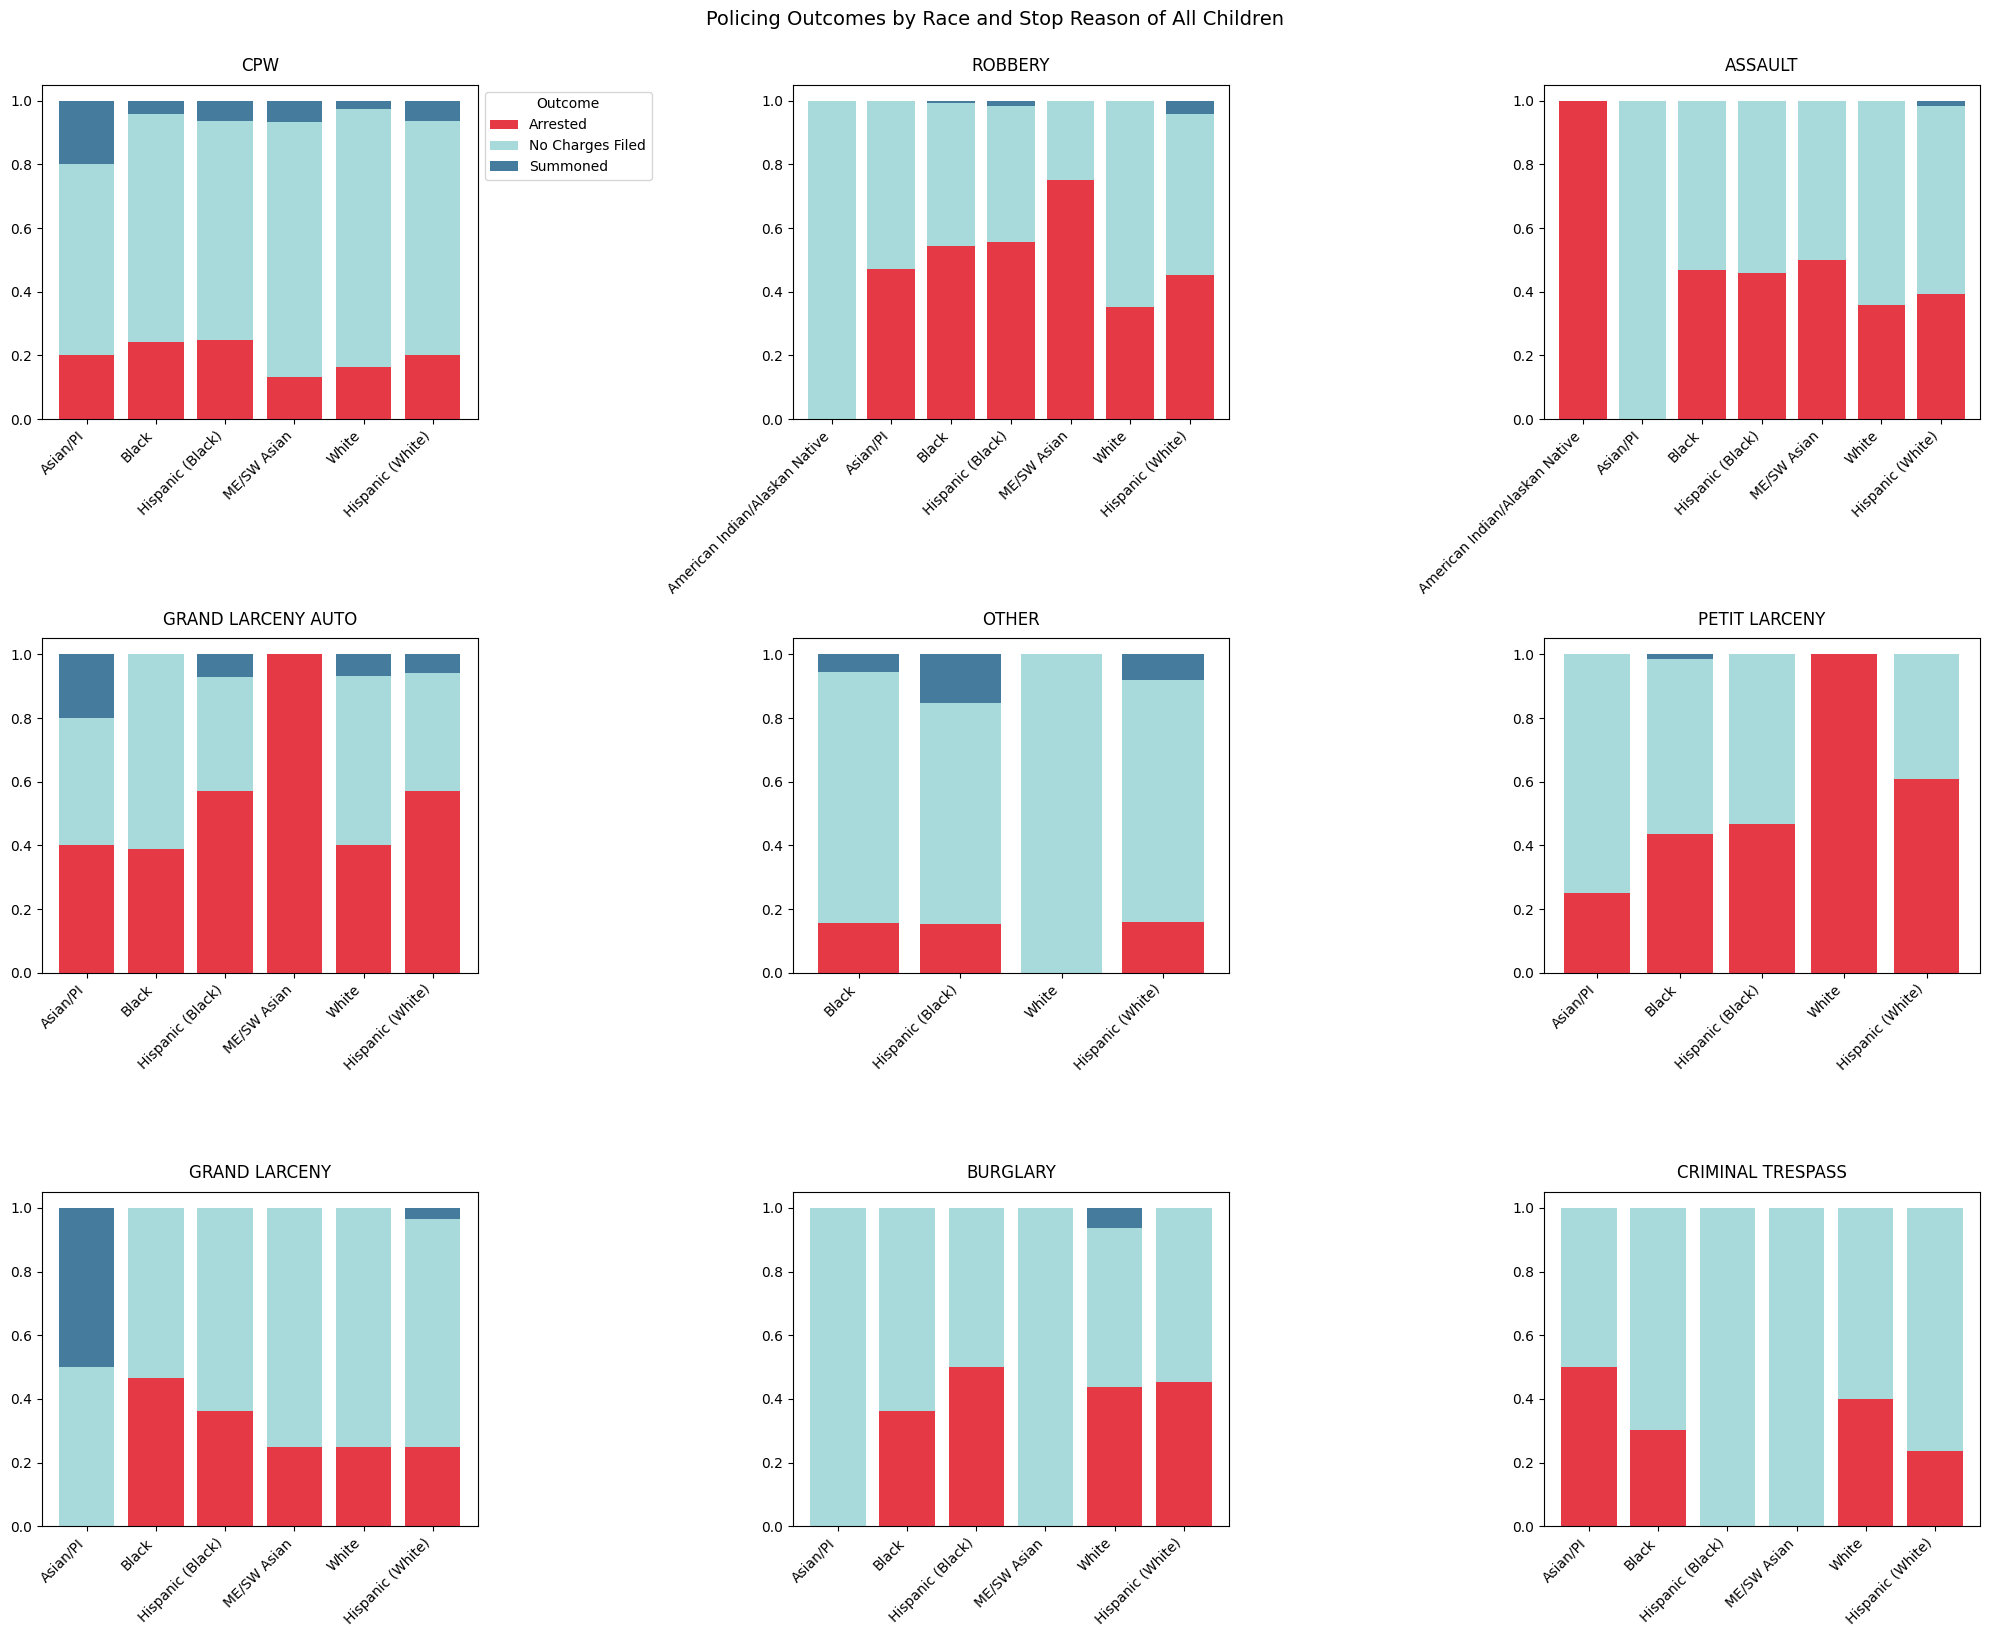

In [ ]:
plot_stop_outcomes(all_children_df, n_reasons=9, figsize=(20,16), plot_title="Policing Outcomes by Race and Stop Reason of All Children")

In [ ]:
# Feel free to take a look for yourself....
all_children_df

,SUSPECT_REPORTED_AGE,SUSPECT_RACE_DESCRIPTION,STOP_WAS_INITIATED,SUSPECTED_CRIME_DESCRIPTION,OFFICER_EXPLAINED_STOP_FLAG,OUTCOME_OF_STOP,FORCE_TYPE,STOP_LOCATION_BORO_NAME
2,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
3,13,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
4,14,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
5,17,WHITE HISPANIC,Based on Radio Run,GRAND LARCENY,True,No Charges Filed,No Force,BROOKLYN
11,17,WHITE,Based on Radio Run,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
...,...,...,...,...,...,...,...,...
20205,17,BLACK HISPANIC,Based on Self Initiated,BURGLARY,True,No Charges Filed,No Force,BROOKLYN
20214,17,WHITE HISPANIC,Based on C/W on Scene,ASSAULT,True,No Charges Filed,No Force,BRONX
20216,14,BLACK,Based on Self Initiated,CPW,True,No Charges Filed,No Force,BRONX
20246,15,BLACK,Based on Radio Run,PETIT LARCENY,True,Arrested,No Force,BROOKLYN


### And it looks like an "early adulthood" for black and brown children
As we enter into the under 18 demographic, we begin to see the bifurcation of childhood based on race in that black and hispanic children are becoming targeted by the police themselves at nearly equal rates as being reported by someone in the child's community.  For black children, the number of stops from their pre-teen life to this teenage life is ~40x the amount of their earlier childhood.   

Moreover, for this age range, all children shot or tased are black and brown.  

## Where's the analysis for all NYers
I've got to get this notebook out the door so I'm omitting an analysis of stops for all New Yorkers here.  Instead, I'll refer the reader to [existing reports](#references) which were used to elucidate this notebook at large.

In [ ]:
full_ny_demo_table = (
    final_df.groupby(['SUSPECT_REPORTED_AGE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(full_ny_demo_table, "All 2024 Stops in NY")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
10,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0
11,0.0,1.0,11.0,2.0,0.0,3.0,3.0,20.0
12,0.0,0.0,39.0,3.0,1.0,6.0,9.0,58.0
13,0.0,2.0,151.0,11.0,6.0,13.0,32.0,215.0
14,2.0,2.0,329.0,28.0,4.0,32.0,77.0,474.0
15,0.0,20.0,469.0,72.0,9.0,24.0,137.0,731.0
16,0.0,8.0,564.0,75.0,7.0,26.0,157.0,837.0


In [ ]:
full_ny_demo_table = (
    final_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,4.0,57.0,"1,158.0",201.0,25.0,161.0,523.0,"2,129.0"
Based on Radio Run,18.0,231.0,"4,780.0",812.0,108.0,738.0,"1,890.0","8,577.0"
Based on Self Initiated,10.0,106.0,"6,269.0",958.0,67.0,315.0,"1,822.0","9,547.0"
TOTAL,32.0,394.0,"12,207.0","1,971.0",200.0,"1,214.0","4,235.0","20,253.0"
% OF TOTAL,0.2%,1.9%,60.3%,9.7%,1.0%,6.0%,20.9%,100.0%


In [ ]:
full_ny_demo_table = (
    final_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,7.0,47.0,876.0,155.0,26.0,113.0,435.0,"1,659.0"
AUTO STRIPPIG,0.0,0.0,7.0,6.0,1.0,4.0,13.0,31.0
AUTO STRIPPING,0.0,0.0,5.0,8.0,0.0,1.0,6.0,20.0
BURGLARY,5.0,39.0,471.0,126.0,17.0,160.0,284.0,"1,102.0"
CPSP,0.0,4.0,51.0,7.0,6.0,13.0,31.0,112.0
CPW,9.0,78.0,"6,859.0",952.0,70.0,280.0,"1,728.0","9,976.0"
CRIMINAL MISCHIEF,1.0,10.0,137.0,25.0,6.0,44.0,59.0,282.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,2.0,44.0,7.0,1.0,20.0,39.0,113.0
CRIMINAL POSSESSION OF FORGED INSTRUMENT,0.0,0.0,6.0,0.0,1.0,0.0,2.0,9.0
CRIMINAL POSSESSION OF MARIHUANA,0.0,0.0,10.0,1.0,0.0,0.0,4.0,15.0


In [ ]:
# Filtering out the no force values since they are the majority for all races, note that its ~1/5th of the cleaned df

full_ny_demo_table = (
    final_df[final_df['FORCE_TYPE'] != "No Force"].groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 

show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Firearm Drawn,2.0,15.0,346.0,60.0,12.0,35.0,111.0,581.0
Handcuffs,5.0,69.0,"1,777.0",281.0,29.0,210.0,623.0,"2,994.0"
Other Physical Force,2.0,14.0,263.0,50.0,9.0,31.0,103.0,472.0
Pepper Spray,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Restraint Used,0.0,4.0,346.0,39.0,1.0,13.0,90.0,493.0
Taser,1.0,0.0,62.0,11.0,1.0,6.0,22.0,103.0
Weapon Impact,0.0,0.0,6.0,0.0,0.0,0.0,2.0,8.0
TOTAL,10.0,102.0,"2,801.0",441.0,52.0,295.0,951.0,"4,652.0"
% OF TOTAL,0.2%,2.2%,60.2%,9.5%,1.1%,6.3%,20.4%,100.0%


In [ ]:
# Filtering out the no force values since they are the majority for all races, note that its ~1/5th of the cleaned df

full_ny_demo_table = (
    final_df.groupby(['OUTCOME_OF_STOP', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 

show_demographic_table(full_ny_demo_table, "What was the suspected crime by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Arrested,8.0,159.0,"3,651.0",575.0,63.0,491.0,"1,338.0","6,285.0"
No Charges Filed,24.0,220.0,"8,091.0","1,326.0",132.0,696.0,"2,744.0","13,233.0"
Summoned,0.0,15.0,465.0,70.0,5.0,27.0,153.0,735.0
TOTAL,32.0,394.0,"12,207.0","1,971.0",200.0,"1,214.0","4,235.0","20,253.0"
% OF TOTAL,0.2%,1.9%,60.3%,9.7%,1.0%,6.0%,20.9%,100.0%


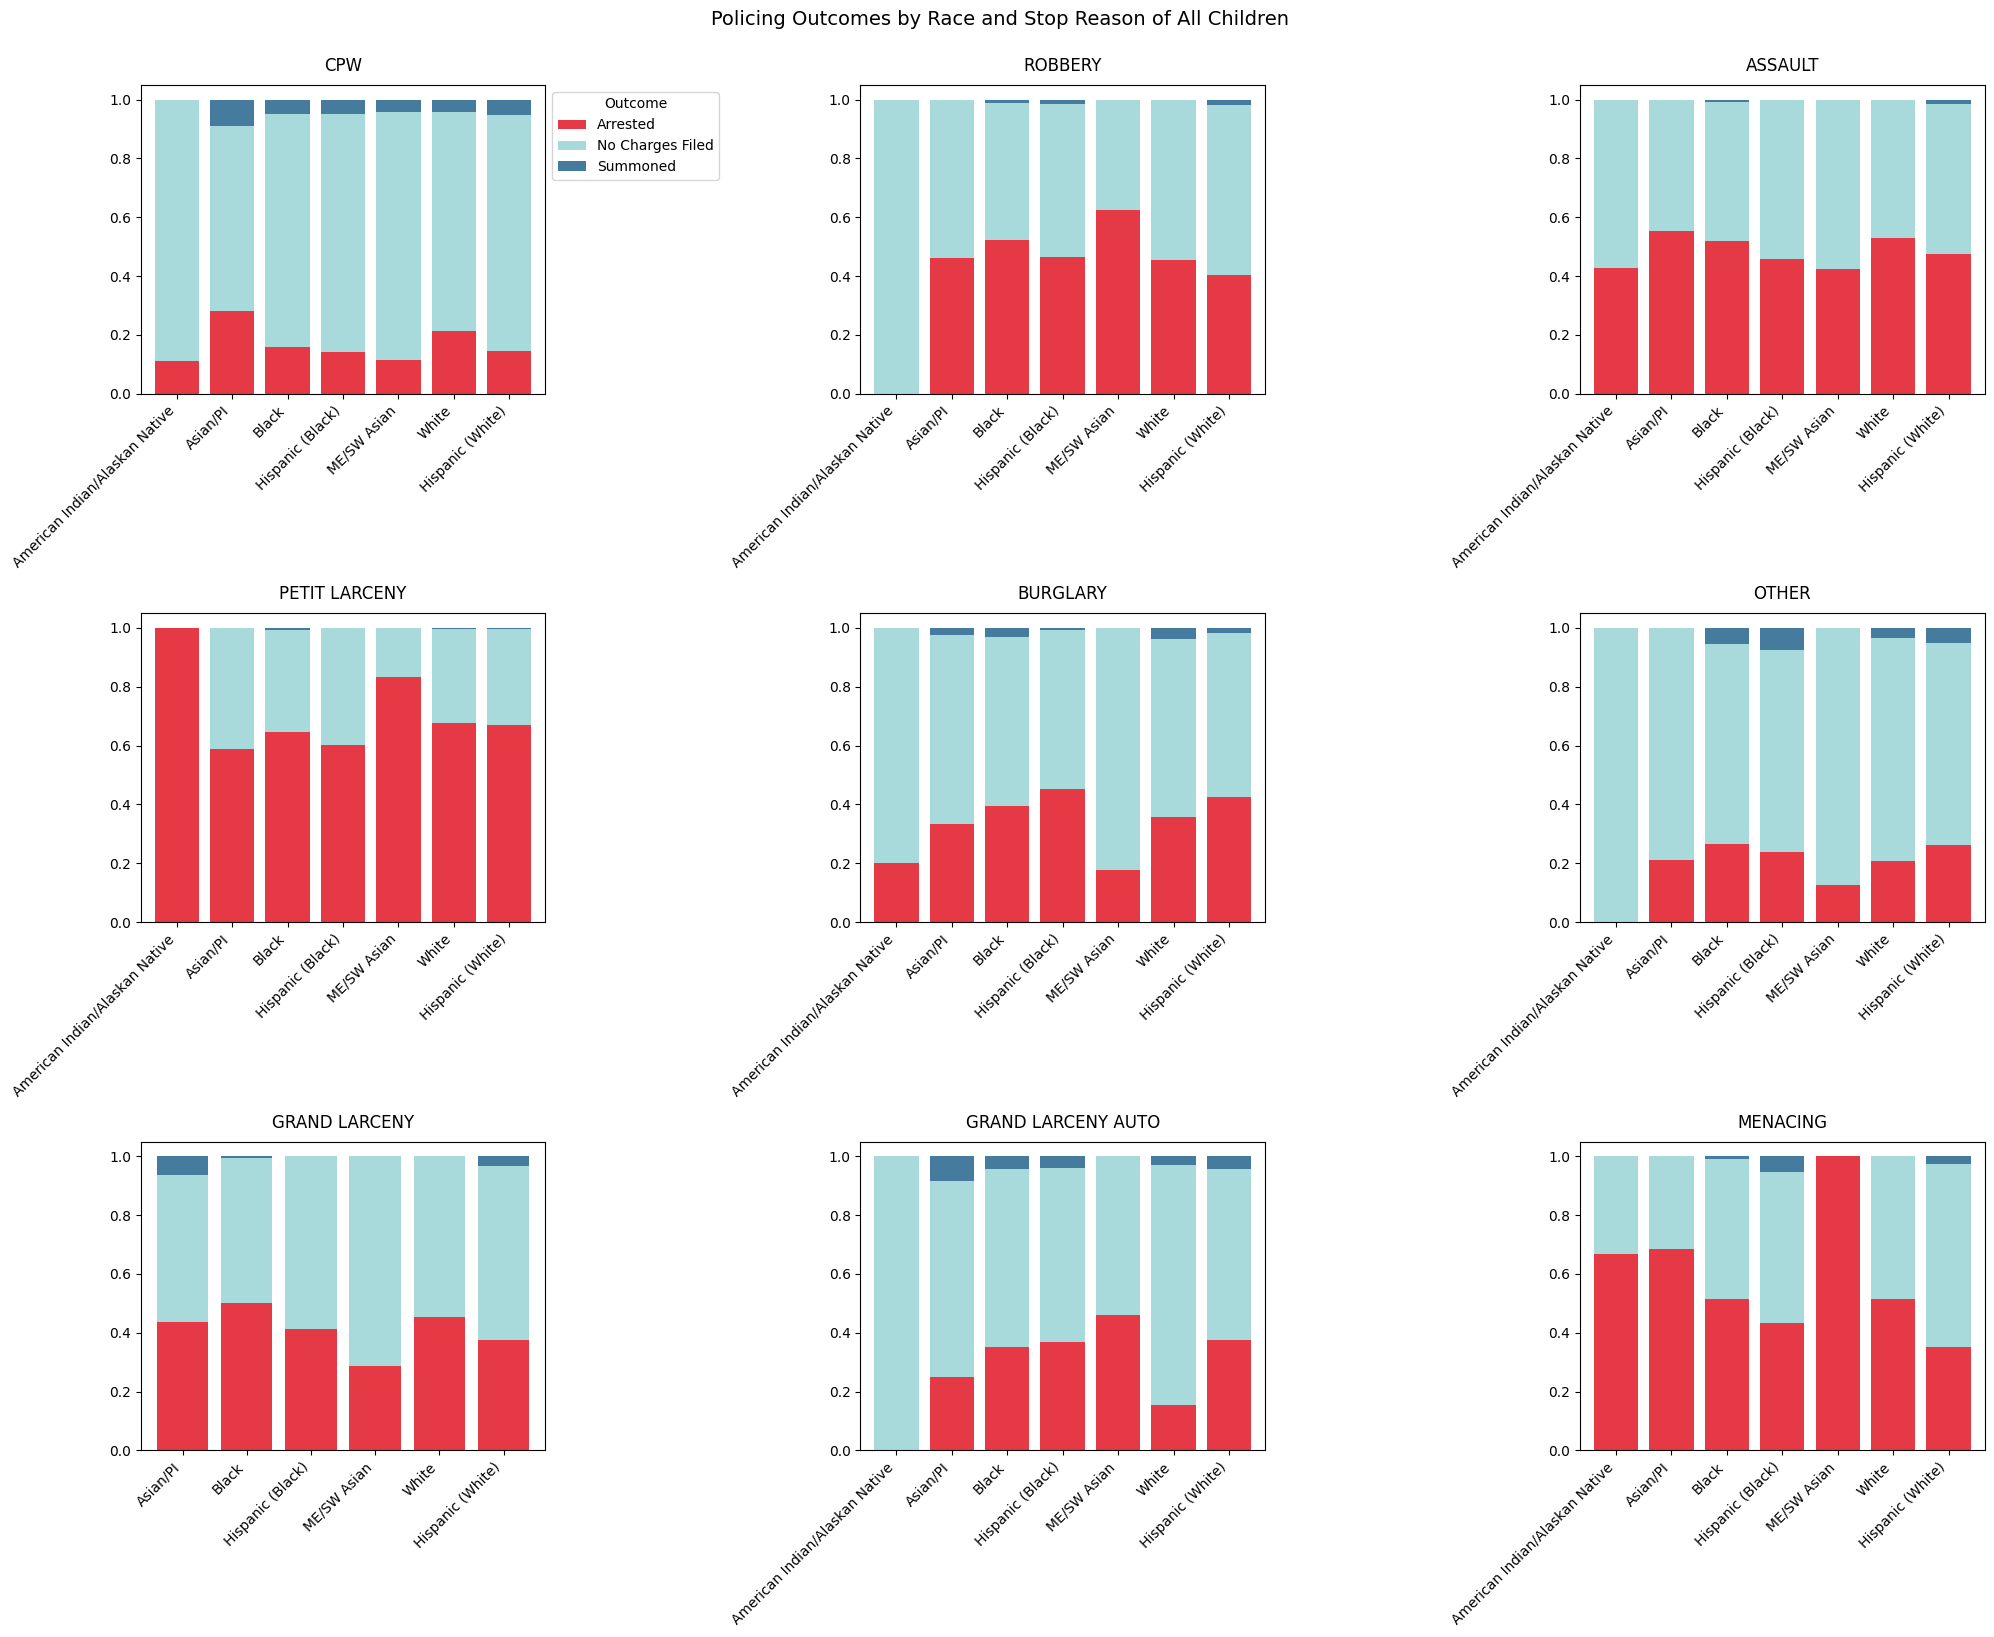

In [ ]:
plot_stop_outcomes(final_df, n_reasons=9, figsize=(20,16), plot_title="Policing Outcomes by Race and Stop Reason of All Children")

## Initial Reflections
- Lots of banding at 18,20,30,40, etc.  seems like the police are rounding.  Given the common practice, I wonder how many children had their ages rounded up to make the stop seem more legitimate.
- And there's a lot of elderly people...
- Only black people were shot

In [ ]:
elderly_df = final_df[final_df["SUSPECT_REPORTED_AGE"] > 65]
elderly_demo_table = (
    elderly_df.groupby(['STOP_WAS_INITIATED', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
)
show_demographic_table(elderly_demo_table, "What inititated the stop of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Based on C/W on Scene,0.0,1.0,14.0,1.0,1.0,7.0,6.0,30.0
Based on Radio Run,0.0,2.0,26.0,2.0,0.0,17.0,11.0,58.0
Based on Self Initiated,1.0,1.0,20.0,1.0,0.0,2.0,3.0,28.0
TOTAL,1.0,4.0,60.0,4.0,1.0,26.0,20.0,116.0
% OF TOTAL,0.9%,3.4%,51.7%,3.4%,0.9%,22.4%,17.2%,100.0%


In [ ]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [ ]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [ ]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [ ]:
elderly_demo_table = (
    elderly_df.groupby(['SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
ASSAULT,0.0,1.0,8.0,0.0,0.0,4.0,4.0,17.0
BURGLARY,0.0,2.0,8.0,0.0,0.0,4.0,1.0,15.0
CPW,0.0,0.0,6.0,1.0,0.0,7.0,4.0,18.0
CRIMINAL MISCHIEF,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0
CRIMINAL POSSESSION OF CONTROLLED SUBSTANCE,0.0,0.0,4.0,0.0,0.0,0.0,1.0,5.0
CRIMINAL SALE OF CONTROLLED SUBSTANCE,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
CRIMINAL TRESPASS,0.0,0.0,4.0,0.0,1.0,1.0,0.0,6.0
FORCIBLE TOUCHING,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
GRAND LARCENY,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
GRAND LARCENY AUTO,0.0,0.0,1.0,0.0,0.0,3.0,0.0,4.0


In [ ]:
elderly_demo_table = (
    elderly_df.groupby(['FORCE_TYPE', 'SUSPECT_RACE_DESCRIPTION'])
    .size()
    .unstack()
    .fillna(0)
    .astype(int)
) 
show_demographic_table(elderly_demo_table, "What was the suspected crime of the Elderly by Age and Race")

SUSPECT_RACE_DESCRIPTION,AMERICAN INDIAN/ALASKAN NATIVE,ASIAN / PACIFIC ISLANDER,BLACK,BLACK HISPANIC,MIDDLE EASTERN/SOUTHWEST ASIAN,WHITE,WHITE HISPANIC,ROW TOTAL
Handcuffs,0.0,0.0,9.0,1.0,1.0,1.0,5.0,17.0
No Force,0.0,4.0,47.0,3.0,0.0,24.0,12.0,90.0
Other Physical Force,1.0,0.0,3.0,0.0,0.0,1.0,3.0,8.0
Restraint Used,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
TOTAL,1.0,4.0,60.0,4.0,1.0,26.0,20.0,116.0
% OF TOTAL,0.9%,3.4%,51.7%,3.4%,0.9%,22.4%,17.2%,100.0%
